# Optimizers

Ebben a részben azzal foglalkozunk, hogy hogyan lehet optimalizálni a hálót. Mindegyik módszer, amit áttekintünk gradiens alapú lesz.

Általánosságban, van egy loss függvényünk, aminek keressük a globális minimumát. Mindengyik loss függvény a minta loss-okból (sample loss) származtatható:

\begin{equation}
L_\Theta\left(y_t, y_p\right) = \frac{1}{n}\sum^n_i { l_\Theta\left(y^{(i)}_t, y^{(i)}_p \right) }.
\end{equation}

Ez azt jelentené, hogy a gradiens kiszámításához a tanító adathalmaz összes mintájára össze kellene adni a minta loss-okat. Ez egy nagyobb méretű adathalmaznál nagyon sokáig tartana. Ezt elkerülendő a a teljes adathalmaz helyett csak batch-eket veszünk. Ez ugyan zajosabb gradienst jelent, de az iterációk gyorsabbak. Várható értékben pedig, ugyanazt a gradienst kapjuk.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multilayer_nn import activations
from multilayer_nn import optimizers

In [2]:
def plot_learning_path(view, loss, path):
    # contruct the x, y plane
    x_min, x_max, y_min, y_max = view
    delta_x = (x_max - x_min) / 100
    delta_y = (y_max - y_min) / 100
    x, y = [], []
    for i in range(101):
        x.append(x_min + delta_x * i)
        y.append(y_min + delta_y * i)
    X, Y = np.meshgrid(x, y)
    
    # calculate the error surface
    Z = loss(X, Y)
    
    # plot the surface and the path in the parameter space
    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10)
    ax.plot(path[0], path[1], 'ro')
    ax.set_title('Learning path with loss contour curves')
    ax.set_xlabel("Theta1")
    ax.set_ylabel("Theta2")

In [3]:
# bemeneti adat
x = np.array([[1.2, 2.0], [1.6, 1.1], [-0.67, -0.2], [-1.14, -1.63], [4.3, 5.5], [3.2, 3.8]])

![optim](https://drive.google.com/uc?export=download&id=1rcb79Qkr_FWljnCNrGyfS3aQ_J0MmHtT)

Az alábbiakban, annak érdekében, hogy kicsit közelebb kerüljünk hozzá, hogy mi történik az egyes optimalizációk esetén egy egyszerű tanuló rendszert fogunk vizsgálni. A fenti ábra mutatja, lényegében egy neuront-t fogunk használni és két paramétere van. Ez lehetővé teszi, hogy illusztráljuk hogyan változik a pozíció a paraméter térben tanulás közben.

\begin{equation}
y = \sigma \left( x_1 \cdot \Theta_1 + x_2 \cdot \Theta_2 \right),
\end{equation}

ahol $\sigma$ a sigmoid függvény. Tegyük fel, hogy a megoldás $\Theta_1 = 0.3$, $\Theta_2 = 0.4$. A kezdő paraméterek legyenek: $\Theta_1 = 5.2$ and $\Theta_2 = 2.7$. MSE loss-t fogunk használni.

In [ ]:
# Az optimális megoldás
theta_0 = np.array([0.3, 0.4])

In [5]:
sigmoid = activations.Sigmoid().activate
def model(theta, x):
    return sigmoid(np.matmul(x, theta))

In [6]:
def grad(theta, x):
    y = model(theta, x)
    y_0 = model(theta_0, x)
    return np.matmul((y - y_0) * y * (1 - y), x) / x.shape[0]

In [7]:
# A function for running an optimization
def optimize(x, op, iter_num, init):
    # x - input in the training set
    # op - optimizer (like Adam)
    # iter_num - number of optimization steps
    path = [[], []]
    theta = [np.array([init[0], init[1]])]
    for ep in range(iter_num):
        path[0].append(theta[0][0])
        path[1].append(theta[0][1])
        np.random.shuffle(x)
        x_batch = x[0:3]
        g = grad(theta[0], x_batch)
        op.optimizer_step(theta, [g])
    view = (min(path[0]), max(path[0]), min(path[1]), max(path[1]))
    return path, view

In [8]:
def loss_generator(x):
    def loss(theta_1, theta_2):
        th = np.array([theta_1, theta_2])
        y = sigmoid(np.tensordot(x, th, axes=(1, 0)).transpose((1, 2, 0)))
        y0 = model(theta_0, x)
        z= np.sum((y - y0) * (y - y0), axis=2)  # MSE loss
        return z
    return loss

loss = loss_generator(x)

## SGD 

SGD, Stochastic Gradient Descent. Az SGD esetén veszünk egy batch-et (mini batch-et) az adathalmazból és azon számoljuk ki a loss-t. Az SGD a learning rate-et és a gradienst nem változtatja menetközben. Tehát nincs aggregáció, átlagolás, hanem közvetlenül alkalmazza.

Formula:

\begin{equation}
\Theta \leftarrow \Theta - \alpha \cdot \frac{\partial L}{\partial \Theta} 
\end{equation}

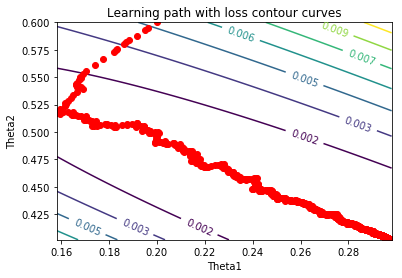

In [9]:
op = optimizers.SGD(1)
path, view = optimize(x, op, 1000, (0.2, 0.6))
plot_learning_path(view, loss, path)

Az SGD gond nélkül megtalálja a megoldást, de relatíve sok iteráció kell és nagy learning rate. A görbe zajos, de nem jellemző, hogy rossz irányba térne el.

## Momentum

A Momentum módszer:

\begin{align}
v_0 &=& 0 \\
v_{t} &=& \gamma \cdot v_{t-1} + \alpha \cdot g \\
\Theta_{t+1} &=& \Theta_t - v_t
\end{align}

ahol $v$ a momentum az eddigi gradiensek aggregációja, $g$ a gradiens vektor. Az intuíció, hogy az eddigi gradienseket is figyelembe véve, a gradiens ellenállób a kis és gyors változásoknak, így stabilabb és gyorsabb lehet a konvergencia. 

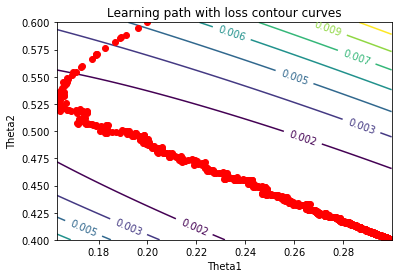

In [10]:
op = optimizers.Momentum(0.95, 1)
path, view = optimize(x, op, 1500, (0.2, 0.6))
plot_learning_path(view, loss, path)

Hasonlít az SGD-hez, de az útja, valamivel stabilabb, kevésbé zajos.

Referencia: [Momentum](https://www.sciencedirect.com/science/article/pii/S0893608098001166?via%3Dihub)

## Adam

A név jelentése Adaptive Moment Estimation. Kombinálja a momentmum módszert az adaptív learning rate módszerrel. Gyorsabban konvergál, agresszívabb. Kevesebb pont a képen, annak ellenére, hogy a learning rate kicsi.

A módszer:

\begin{align}
m_0 &=& 0 \\
v_0 &=& 0 \\
m_t &=& \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g \\
v_t &=& \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g \cdot g \\
\hat{m} &=& \frac{m_t}{1 - \beta^t_1} \\
\hat{v} &=& \frac{v_t}{1 - \beta^t_2} \\
\Theta_{t+1} &=& \Theta_t - \alpha \cdot \frac{1}{\sqrt{\hat{v}}} \cdot \hat{m}
\end{align}

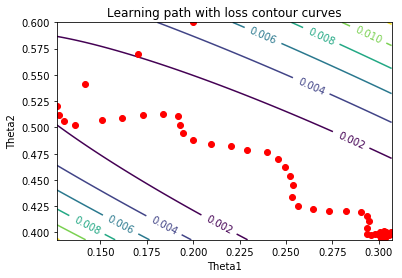

In [11]:
op = optimizers.Adam(0.8, 0.9, 0.03)
path, view = optimize(x, op, 50, (0.2, 0.6))
plot_learning_path(view, loss, path)

Referencia:
[Adam](https://arxiv.org/pdf/1412.6980.pdf)

## RMSProp

A formulák:

\begin{align}
G_0 &=& 0 \\
G_t &=& \gamma \cdot G_{t-1} + (1 - \gamma) \cdot g \cdot g \\
\Theta_t &=& \Theta_{t-1} - \frac{\alpha}{\sqrt{G_t}} \cdot g
\end{align}

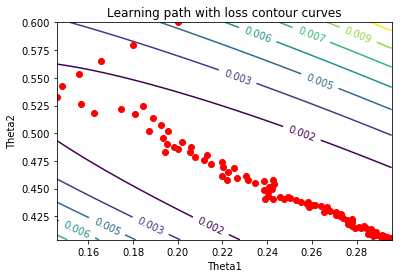

In [13]:
op = optimizers.RMSProp(0.02, 0.02)
path, view = optimize(x, op, 100, (0.2, 0.6))
plot_learning_path(view, loss, path)

Referencia: [RMSProp](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

### További irodalom

[Overview of optimizers by Ruder](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) <br/>